<a href="https://colab.research.google.com/github/sidg0113/NMR-evaluation/blob/main/NMR_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Evaluation Task: Decoding quantum states through nuclear magnetic resonance**


**OVERVIEW**

*   Nuclear Magnetic Resonance (NMR) is an experimental technique that allows   for the control and measurement of nuclear spins in crystals and molecules.
*   A common "recipe" for NMR is called the spin echo: the spins are aligned, let loose, and then refocused, making a sharp peak, or "echo", of the original alignment. When the spins interact with each other, the refocused echo in the magnetization $M$ can become highly distorted.


*   Materials with strong electron-electron couplings show a wide variety of phenomena, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.


*   In this evaluation, you will desgin and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$.

*   The four (4) evaluation tasks follow after an introduction to the problem and code which downloads the dataset you will use.


**INTRODUCTION TO NMR AND SPIN ECHOS**

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!

The red arrows in this animation represents the values of nuclear spins in the material. They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse). A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.
Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.
After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane. After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing "backwards" compared to the original motion! So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.
This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments. This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.




**ELECTRONIC AND NUCLEAR SPINS**

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor. These terms are based on a semi-classical description of the electrons in a crystal. The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy. In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling. Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction). If the electron-nuclear coupling becomes strong enough (enhanced perhaps by a "qunatum" electronic phase), then a non-neglible two-step process can couple the nuclei with each other throughout the material. That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$, given by:

$T(i,j) = \alpha \left( \frac{ \left|r_j - r_i \right|}{\xi} \right)^{-p}$

where $\alpha$ is the coupling strength, $\xi$ the coupling length, and $p$ the power-law of the coupling. Generally, $\alpha$, $\xi$, and $p$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if the spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost". This occurs at a time scale $T_\textrm{decay} \simeq \Gamma^{-1/2}$, with $\Gamma$ given by:

$\Gamma = 10^{-d}$

In the simulated data-sets, the parameters are randomly distributed over the following ranges:
$\alpha$: coupling strength $\in$ [0.0, 0.2]

$\xi$: coupling length $\in$ [0, 20]

$p$: coupling power $\in$ [2, 4]

$d$: dissipation power $\in$ [3, 6]

Our goal is to develop a model that accurately determines the above four variables from a single $M(t)$ curve.

**LOADING AND VIEWING THE DATA**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,BayesianRidge
from sklearn.model_selection import train_test_split

In [2]:
mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1UZ8wy1Vh4iW1GyaBfWtmjnrKXeDmA2rJ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1G82krEg6SVB-PFOS3ei-EH4ZOcseSIEe",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1h8MHtV_rQg4TG-YGXqRaDzJU8oRrypCD",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=14-oz_3OGsTFziJI1FUg0EenMcdQDf2F_",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Add2V9cYOBbOCvr1Dj-g4yMlx3LdJY8i",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i
print("Done with numpy loads")

Done with file downloads
Loading into numpy arrays...
Done with numpy loads


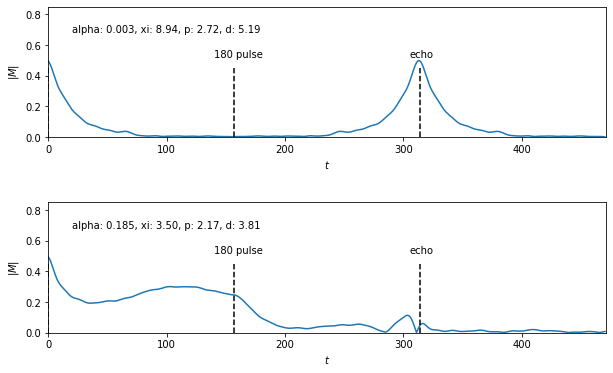

In [3]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(2,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 0; # weak spin-spin coupling
plot_idx2 = 10; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, p: %.2f, d: %.2f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");


fig1.subplots_adjust(hspace=.5)

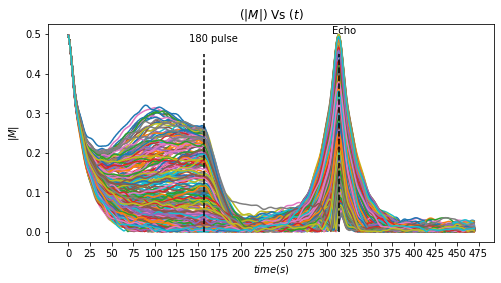

In [4]:
fig, ax = plt.subplots(1, figsize=(8, 4))

for i in range(500):
    ax.plot(np.abs(M[i,:]))
    
ax.plot([2*157, 2*157],[0, .45],'--k')
ax.plot([157, 157],[0, .45],'--k')
ax.text(140,0.48,"180 pulse")
ax.text(305,0.50,"Echo")
ax.set(ylabel="$|M|$", xlabel="$time (s)$");
ax.set_title("($|M|$) Vs ($t$)",fontsize=12)
ax.set_xticks(np.arange(0,476,25))
plt.show()

In [5]:
X_train,X_test,y_train,y_test=train_test_split(np.abs(M),mat_info,test_size=0.15,random_state=42)

**LINEAR MODELS:**

Models considered are:

1.   Linear regression
2.   Ridge regression
3.   Lasso regression



*ALPHA*

In [6]:
model1=LinearRegression(normalize=True)
feature_select1=SelectKBest(score_func=f_regression,k=350)
y1_train=y_train[:,0]
x1_train=feature_select1.fit_transform(X_train,y1_train)
model1.fit(x1_train,y1_train)
x1_test=feature_select1.transform(X_test)
predict_alpha=model1.predict(x1_test)


In [7]:
sklearn.metrics.mean_squared_error(y_test[:,0],predict_alpha)

8.995617331946734e-06

Text(0, 0.5, 'predicted alpha')

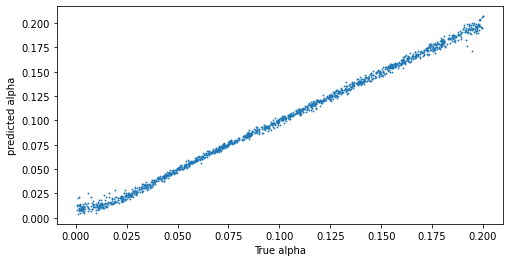

In [8]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 0], predict_alpha, s=0.7)
ax.set_xlabel("True alpha")
ax.set_ylabel("predicted alpha")

*Xi:*

In [9]:
model2=BayesianRidge(normalize=True)
feature_select2=SelectKBest(score_func=f_regression,k=100)
y2_train=y_train[:,1]
x2_train=feature_select2.fit_transform(X_train,y2_train)
model2.fit(x2_train,y2_train)
x2_test=feature_select2.transform(X_test)
predict_xi=model2.predict(x2_test)


In [10]:
sklearn.metrics.mean_squared_error(y_test[:,1],predict_xi)

34.73690023490472

Text(0, 0.5, 'predicted xi')

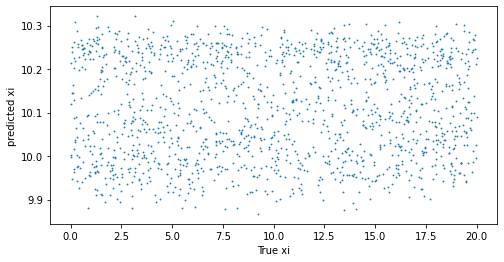

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 1], predict_xi, s=0.7)
ax.set_xlabel("True xi")
ax.set_ylabel("predicted xi")

*P:*

In [12]:
model3=BayesianRidge(normalize=True)
feature_select3=SelectKBest(score_func=f_regression,k=471)
y3_train=y_train[:,2]
x3_train=feature_select3.fit_transform(X_train,y3_train)
model3.fit(x3_train,y3_train)
x3_test=feature_select3.transform(X_test)
predict_p=model3.predict(x3_test)

In [13]:
sklearn.metrics.mean_squared_error(y_test[:,2],predict_p)

0.08853301664199341

Text(0, 0.5, 'predicted p')

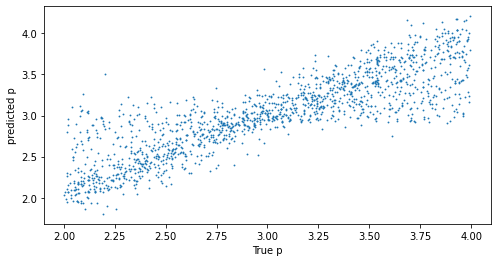

In [14]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 2], predict_p, s=0.7)
ax.set_xlabel("True p")
ax.set_ylabel("predicted p")

**D:**

In [15]:
model4=LinearRegression()
feature_select4=SelectKBest(score_func=f_regression,k=150)
y4_train=y_train[:,3]
x4_train=feature_select4.fit_transform(X_train,y4_train)
model4.fit(x4_train,y4_train)
x4_test=feature_select4.transform(X_test)
predict_d=model4.predict(x4_test)

In [16]:
sklearn.metrics.mean_squared_error(y_test[:,3],predict_d)

0.2915208901158978

Text(0, 0.5, 'predicted d')

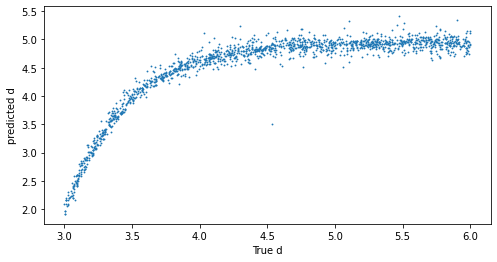

In [17]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 3], predict_d, s=0.7)
ax.set_xlabel("True d")
ax.set_ylabel("predicted d")

**CNN:**

This is a custom built model inspired from time series regression:https://arxiv.org/pdf/2006.12672.pdf

In [18]:
import tensorflow as tf
import keras as keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout
import requests
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D

In [19]:
def cnn(X_train,adam_lr):
  input_layer = tf.keras.layers.Input(shape=(X_train.shape[1], 1), dtype=tf.float64)

  conv1 = tf.keras.layers.Conv1D(filters=64,
                                       kernel_size=30,
                                       padding='same')(input_layer)
  conv1 = tf.keras.layers.Activation(activation='relu')(conv1)
  pool1 = tf.keras.layers.MaxPool1D(pool_size=3, strides=1)(conv1)
  dropout1=tf.keras.layers.Dropout(0.1)(pool1)
  conv2 = tf.keras.layers.Conv1D(filters=64,
                                       kernel_size=30,
                                       padding='same')(dropout1)
  conv2 = tf.keras.layers.Activation('relu')(conv2)

  conv3 = tf.keras.layers.Conv1D(64,
                                       kernel_size=4,
                                       padding='same')(conv2)
  conv3 = tf.keras.layers.Activation('relu')(conv3)
  pool2=tf.keras.layers.AveragePooling1D(pool_size=3,strides=1)(conv3)
  flatten=tf.keras.layers.Flatten()(pool2)
  dense1 = tf.keras.layers.Dense(units=400, activation='relu')(flatten)
  dropout2 = tf.keras.layers.Dropout(0.1)(dense1)
  dense2 = tf.keras.layers.Dense(units=20, activation='relu')(dropout2)
  output_layer = tf.keras.layers.Dense(1, activation='linear')(dense2)
  loss = tf.keras.losses.MeanSquaredError()
  metrics=['mse']
  optimizer = tf.keras.optimizers.Adam(learning_rate=adam_lr)
  model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer,name='fcnn')
  model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)
  return model

In [20]:
cnn_alpha=cnn(X_train,1e-4)

In [21]:
cnn_alpha.fit(X_train,y_train[:,0],validation_split=0.1,epochs=50,batch_size=64)

Epoch 1/50
120/120 [==============================] - 34s 40ms/step - loss: 5.4651e-04 - mse: 5.4651e-04 - val_loss: 5.0014e-05 - val_mse: 5.0014e-05
Epoch 2/50
120/120 [==============================] - 4s 36ms/step - loss: 5.8662e-05 - mse: 5.8662e-05 - val_loss: 7.6064e-05 - val_mse: 7.6064e-05
Epoch 3/50
120/120 [==============================] - 4s 36ms/step - loss: 4.8863e-05 - mse: 4.8863e-05 - val_loss: 3.1521e-05 - val_mse: 3.1521e-05
Epoch 4/50
120/120 [==============================] - 4s 36ms/step - loss: 4.5879e-05 - mse: 4.5879e-05 - val_loss: 3.0060e-05 - val_mse: 3.0060e-05
Epoch 5/50
120/120 [==============================] - 4s 36ms/step - loss: 3.7294e-05 - mse: 3.7294e-05 - val_loss: 4.6313e-05 - val_mse: 4.6313e-05
Epoch 6/50
120/120 [==============================] - 4s 35ms/step - loss: 3.4295e-05 - mse: 3.4295e-05 - val_loss: 5.9120e-05 - val_mse: 5.9120e-05
Epoch 7/50
120/120 [==============================] - 4s 35ms/step - loss: 3.2252e-05 - mse: 3.2252e-05 -

In [22]:
predicted_cnn_alpha=cnn_alpha.predict(X_test)

In [23]:
sklearn.metrics.mean_squared_error(y_test[:,0],predicted_cnn_alpha)

5.366075895989899e-06

Text(0, 0.5, 'predicted alpha')

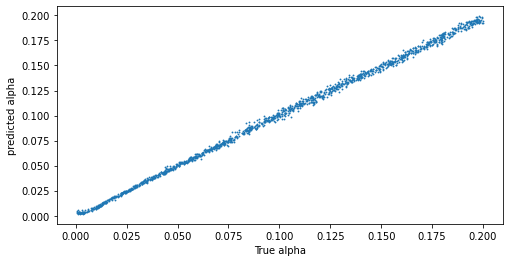

In [24]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 0], predicted_cnn_alpha, s=0.7)
ax.set_xlabel("True alpha")
ax.set_ylabel("predicted alpha")

In [25]:
cnn_xi=cnn(X_train,1e-4)

In [26]:
cnn_xi.fit(X_train,y_train[:,1],validation_split=0.1,epochs=30,batch_size=64)

Epoch 1/30
120/120 [==============================] - 5s 37ms/step - loss: 47.9107 - mse: 47.9107 - val_loss: 35.2915 - val_mse: 35.2915
Epoch 2/30
120/120 [==============================] - 4s 35ms/step - loss: 34.9332 - mse: 34.9332 - val_loss: 34.1728 - val_mse: 34.1728
Epoch 3/30
120/120 [==============================] - 4s 35ms/step - loss: 34.6856 - mse: 34.6856 - val_loss: 33.8371 - val_mse: 33.8371
Epoch 4/30
120/120 [==============================] - 4s 36ms/step - loss: 34.3244 - mse: 34.3244 - val_loss: 34.3454 - val_mse: 34.3454
Epoch 5/30
120/120 [==============================] - 4s 35ms/step - loss: 34.2580 - mse: 34.2580 - val_loss: 34.2492 - val_mse: 34.2492
Epoch 6/30
120/120 [==============================] - 4s 35ms/step - loss: 34.5019 - mse: 34.5019 - val_loss: 33.9162 - val_mse: 33.9162
Epoch 7/30
120/120 [==============================] - 4s 35ms/step - loss: 34.3979 - mse: 34.3979 - val_loss: 34.1762 - val_mse: 34.1762
Epoch 8/30
120/120 [=====================

In [27]:
predicted_cnn_xi=cnn_xi.predict(X_test)

In [28]:
sklearn.metrics.mean_squared_error(y_test[:,1],predicted_cnn_xi)

34.94242390128059

Text(0, 0.5, 'predicted xi')

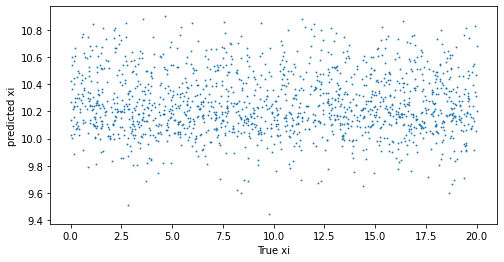

In [29]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 1], predicted_cnn_xi, s=0.7)
ax.set_xlabel("True xi")
ax.set_ylabel("predicted xi")

In [30]:
cnn_p=cnn(X_train,1e-4)

In [31]:
cnn_p.fit(X_train,y_train[:,2],validation_split=0.1,epochs=200,batch_size=64)

Epoch 1/200
120/120 [==============================] - 5s 38ms/step - loss: 1.0992 - mse: 1.0992 - val_loss: 0.2474 - val_mse: 0.2474
Epoch 2/200
120/120 [==============================] - 4s 36ms/step - loss: 0.2427 - mse: 0.2427 - val_loss: 0.1980 - val_mse: 0.1980
Epoch 3/200
120/120 [==============================] - 4s 36ms/step - loss: 0.2029 - mse: 0.2029 - val_loss: 0.1608 - val_mse: 0.1608
Epoch 4/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1655 - mse: 0.1655 - val_loss: 0.1651 - val_mse: 0.1651
Epoch 5/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1520 - mse: 0.1520 - val_loss: 0.1249 - val_mse: 0.1249
Epoch 6/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1400 - mse: 0.1400 - val_loss: 0.1425 - val_mse: 0.1425
Epoch 7/200
120/120 [==============================] - 4s 36ms/step - loss: 0.1328 - mse: 0.1328 - val_loss: 0.1077 - val_mse: 0.1077
Epoch 8/200
120/120 [==============================] - 4s 36ms

In [32]:
predicted_cnn_p=cnn_p.predict(X_test)

In [33]:
sklearn.metrics.mean_squared_error(y_test[:,2],predicted_cnn_p)

0.06542287451933447

Text(0, 0.5, 'predicted p')

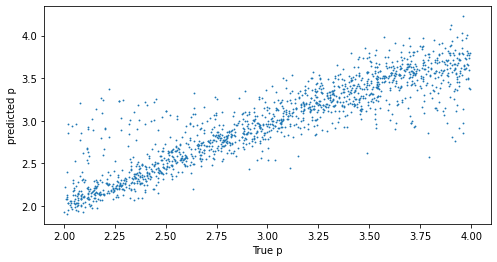

In [34]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 2], predicted_cnn_p, s=0.7)
ax.set_xlabel("True p")
ax.set_ylabel("predicted p")

In [35]:
cnn_d=cnn(X_train,1e-4)

In [36]:
cnn_d.fit(X_train,y_train[:,3],validation_split=0.1,epochs=150,batch_size=64)

Epoch 1/150
120/120 [==============================] - 5s 38ms/step - loss: 3.3046 - mse: 3.3046 - val_loss: 0.7662 - val_mse: 0.7662
Epoch 2/150
120/120 [==============================] - 4s 36ms/step - loss: 0.7598 - mse: 0.7598 - val_loss: 0.6578 - val_mse: 0.6578
Epoch 3/150
120/120 [==============================] - 4s 36ms/step - loss: 0.6890 - mse: 0.6890 - val_loss: 0.6504 - val_mse: 0.6504
Epoch 4/150
120/120 [==============================] - 4s 35ms/step - loss: 0.6710 - mse: 0.6710 - val_loss: 0.6236 - val_mse: 0.6236
Epoch 5/150
120/120 [==============================] - 4s 36ms/step - loss: 0.6555 - mse: 0.6555 - val_loss: 0.6078 - val_mse: 0.6078
Epoch 6/150
120/120 [==============================] - 4s 35ms/step - loss: 0.6436 - mse: 0.6436 - val_loss: 0.5833 - val_mse: 0.5833
Epoch 7/150
120/120 [==============================] - 4s 36ms/step - loss: 0.6184 - mse: 0.6184 - val_loss: 0.5944 - val_mse: 0.5944
Epoch 8/150
120/120 [==============================] - 4s 35ms

In [37]:
predicted_cnn_d=cnn_d.predict(X_test)

In [38]:
sklearn.metrics.mean_squared_error(y_test[:,3],predicted_cnn_d)

0.2718940885636076

Text(0, 0.5, 'predicted d')

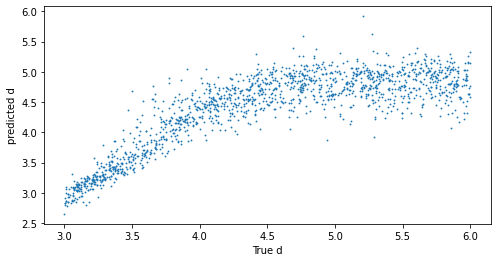

In [39]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.scatter(y_test[:, 3], predicted_cnn_d, s=0.7)
ax.set_xlabel("True d")
ax.set_ylabel("predicted d")

**CONCLUSION:**



1.   Alpha was predicted equally well by the cnn and linear model.
2.   Better methods need to be devised for prediction of xi.
3.   P was predicted equally well by the linear model and the cnn.
4.   The loss for d was less using the cnn model.

